In [1]:
import json
import sys
import gc
import os
import uproot
import dask

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')

import numpy       as np
import pandas      as pd
import hipy.pltext as pltext
import awkward     as ak
import matplotlib.pyplot as plt

from wcte.brbtools import sort_run_files, get_part_files, select_good_parts
from tqdm          import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

In [2]:
run        = 1626
run_files  = sort_run_files(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
part_files = get_part_files(run_files)
good_parts = select_good_parts(part_files, run_files)

Selecting Good Parts: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


In [3]:
with open('/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/mmc_map_R1609.json') as f:
    mcc_map = json.load(f)

d = {}
for k,v in zip(mcc_map.keys(), mcc_map.values()):
    card, channel = [int(i) for i in str(int(k)/100).split(".")]
    d[(card, channel)] = v

mcc_map = d

In [4]:
import dask
import awkward as ak
import numpy as np
import uproot

def read_uproot_file(file_path, evt_offset):
    tree = uproot.open(file_path + ":WCTEReadoutWindows")
    
    file_hit_card_ids = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_times = tree["hit_pmt_times"].array()
    file_hit_charges = tree["hit_pmt_charges"].array()
    event_number = tree["event_number"].array()
    
    # Corrected: Broadcast against hit data to get per-hit event numbers
    file_event_number = ak.flatten(ak.broadcast_arrays(event_number + evt_offset, file_hit_card_ids)[0])
    
    return (
        ak.flatten(file_hit_card_ids),
        ak.flatten(file_hit_channel_ids),
        file_event_number,
        ak.flatten(file_hit_times),
        ak.flatten(file_hit_charges)
    )

@dask.delayed
def process_part(file_path, evt_offset, mcc_map):
    flat_card_ids, flat_chan_ids, file_event_number, flat_times, flat_charges = read_uproot_file(file_path, evt_offset)
    
    # Construcción de la lookup table vectorizada
    cards = ak.to_numpy(flat_card_ids)
    chans = ak.to_numpy(flat_chan_ids)
    max_card, max_chan = np.max(cards), np.max(chans)
    
    lookup = np.zeros((max_card + 1, max_chan + 1))
    for (c, ch), val in mcc_map.items():
        if c <= max_card and ch <= max_chan:
            lookup[c, ch] = val
    
    # Cálculos vectorizados
    corrections = lookup[cards, chans]
    ts_wrap_correction = (ak.to_numpy(file_event_number) + (1 // 512)) * (2**32 * 8)
    corrected_times = ak.Array(ak.to_numpy(flat_times) + corrections + ts_wrap_correction)
    
    return (
        file_event_number,
        corrected_times,
        flat_card_ids,
        flat_chan_ids,
        flat_charges
    )

# Precomputar offsets
print("1")
original_max_evts = []
for part in good_parts:
    tree = uproot.open(run_files[part] + ":WCTEReadoutWindows")
    event_number = tree["event_number"].array()
    original_max_evts.append(ak.max(event_number))

print("2")
evt_offsets = [0]
for i in range(1, len(good_parts)):
    evt_offsets.append(evt_offsets[i-1] + original_max_evts[i-1] + 1)

print("3")
# Procesamiento paralelo
delayed_parts = [
    process_part(run_files[part], evt_offsets[i], mcc_map)
    for i, part in enumerate(good_parts)
]

print("4")
results = dask.compute(delayed_parts, scheduler='processes')[0]

print("5")
# Concatenación final
run_events = ak.concatenate([r[0] for r in results])
run_times = ak.concatenate([r[1] for r in results])
run_cards = ak.concatenate([r[2] for r in results])
run_chans = ak.concatenate([r[3] for r in results])
run_charge = ak.concatenate([r[4] for r in results])

1
2
3
4
5


In [6]:
subset_event = run_events[::10000]
subset_times = run_times[::10000]
subset_charges = run_charge[::10000]

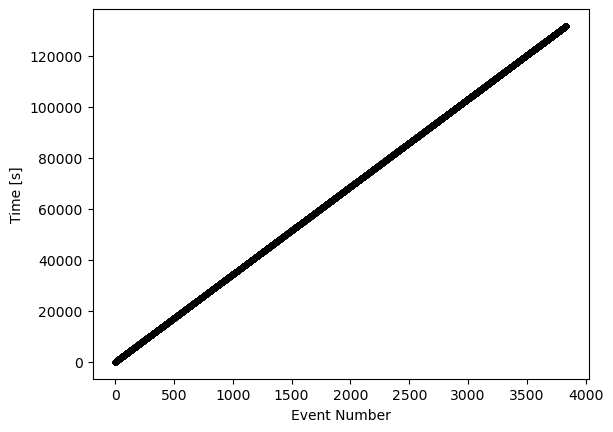

In [9]:
plt.scatter(subset_event, subset_times/1e9, marker=".");
plt.ylabel("Time [s]");
plt.xlabel("Event Number");

In [10]:
cards = np.unique(run_cards)

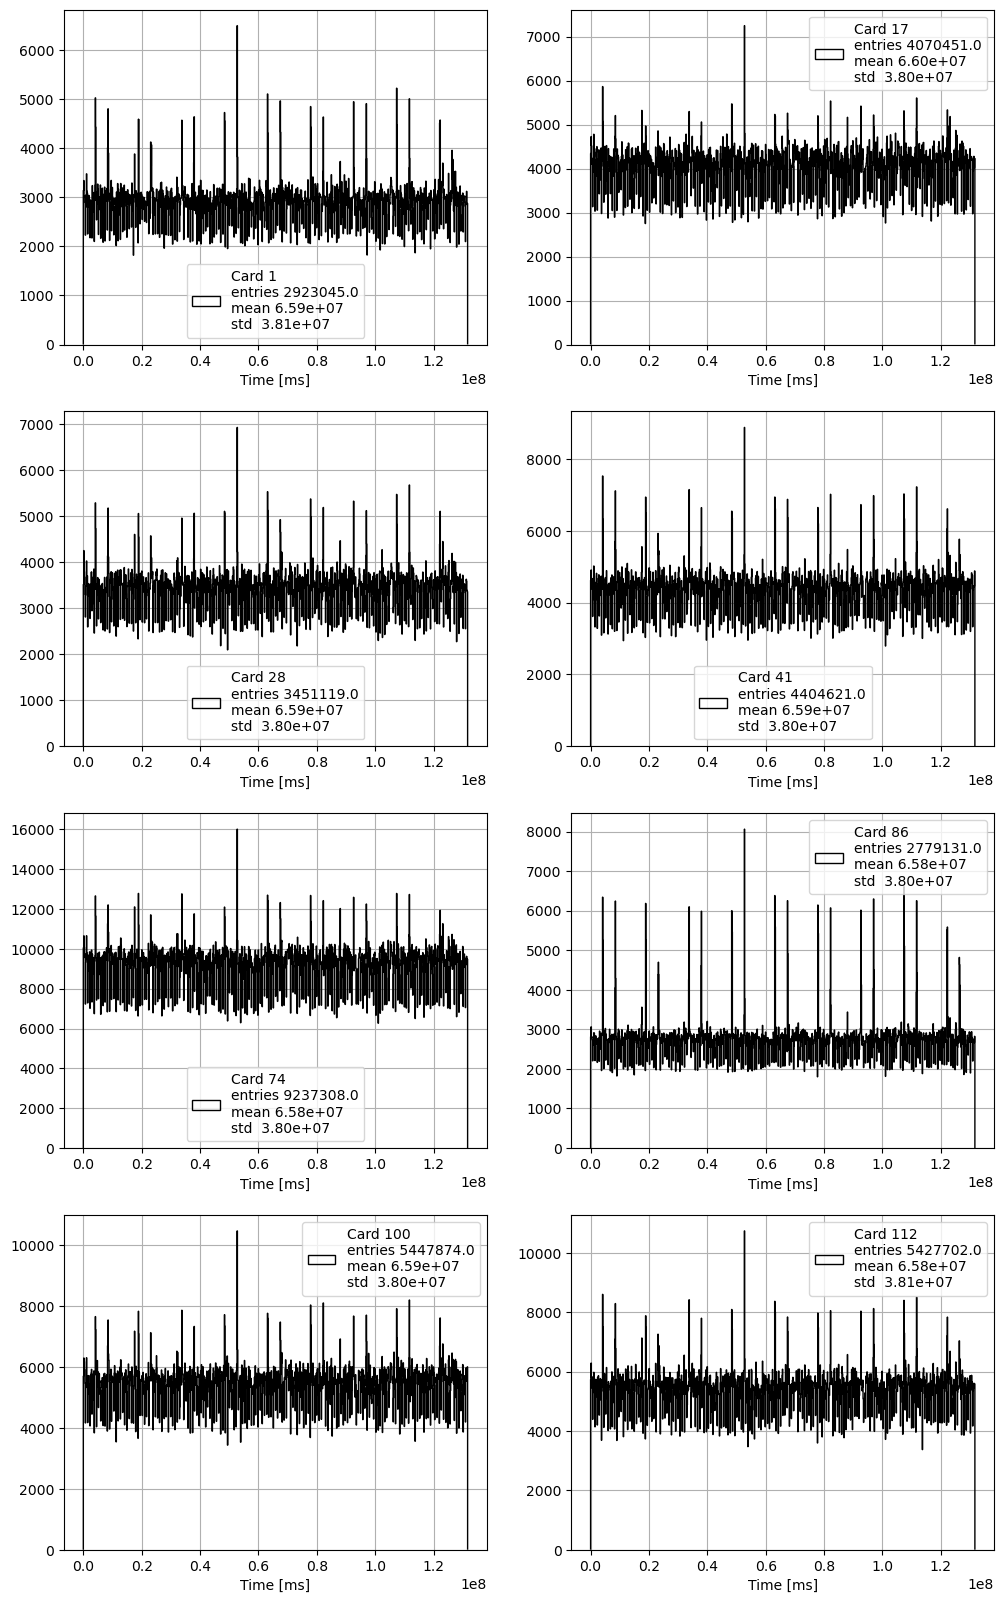

In [11]:
subplot = pltext.canvas(8)

for i, card in enumerate(cards[::11]):
    mask = (run_cards == card)
    card_hit_times = run_times[mask]

    subplot(i+1)
    pltext.hist(card_hit_times/1e6, 1000, xylabels=("Time [ms]"), label=f"Card {card}", formate='.2e');


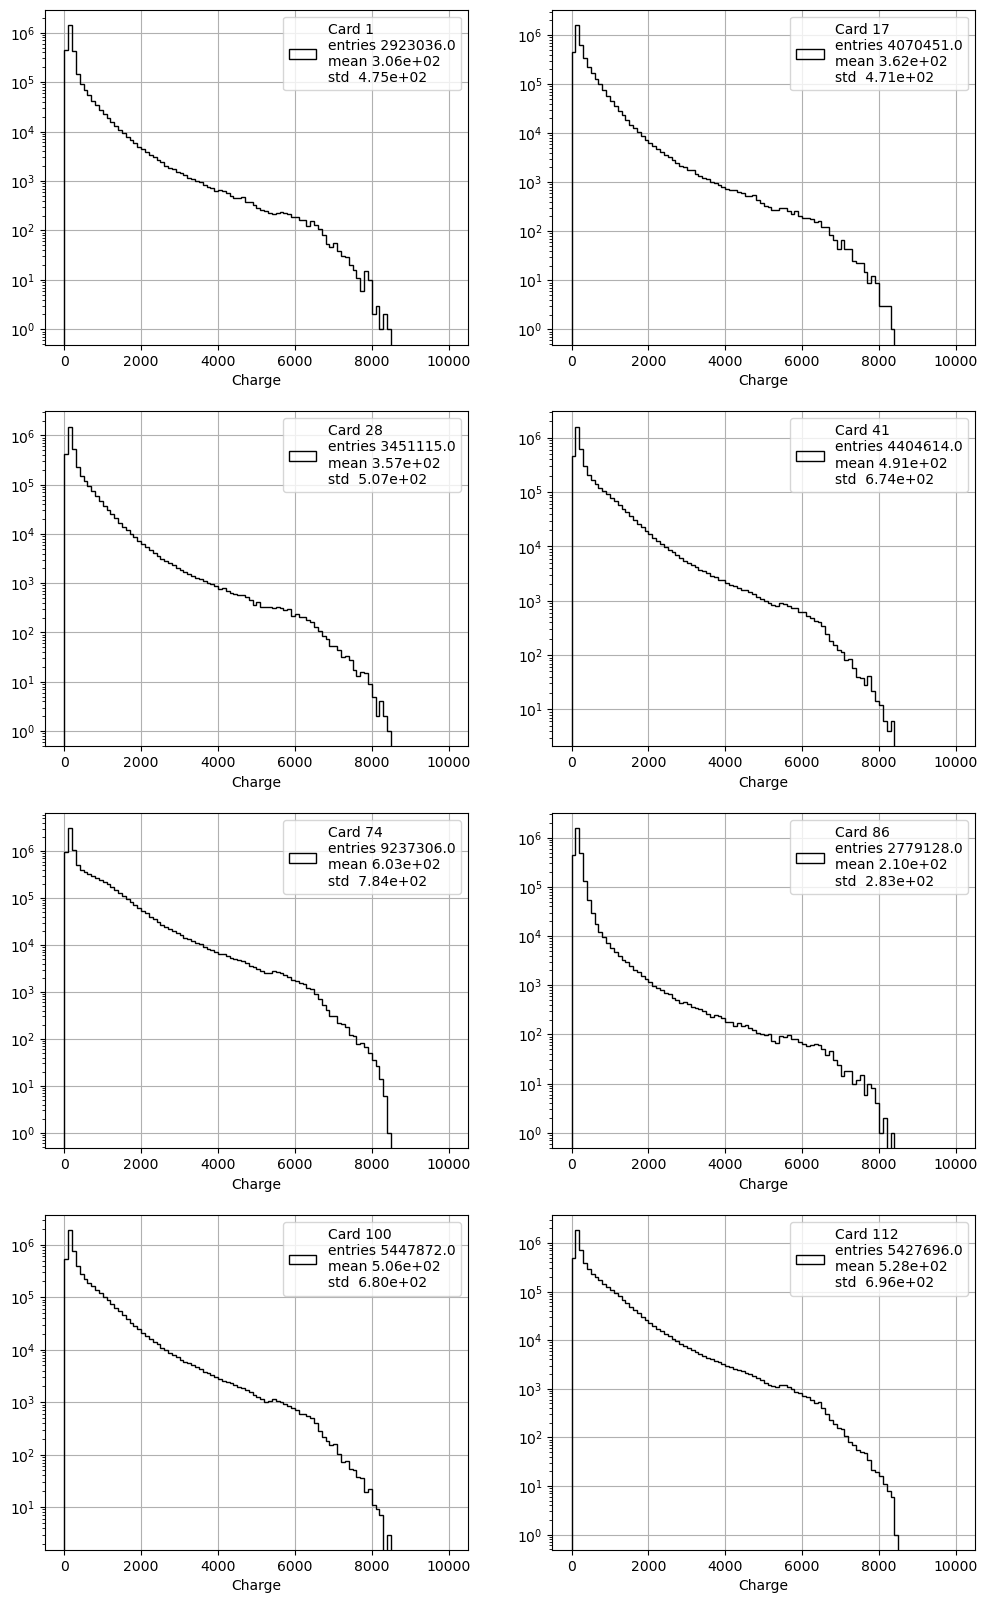

In [12]:
subplot = pltext.canvas(8)

for i, card in enumerate(cards[::11]):
    mask = (run_cards == card)
    card_hit_charges = run_charge[mask]

    subplot(i+1)
    pltext.hist(card_hit_charges, 100, xylabels=("Charge"), range=(0, 10000), ylog=True, label=f"Card {card}", formate='.2e');

In [13]:
events, nhits = np.unique(run_events, return_counts=True)

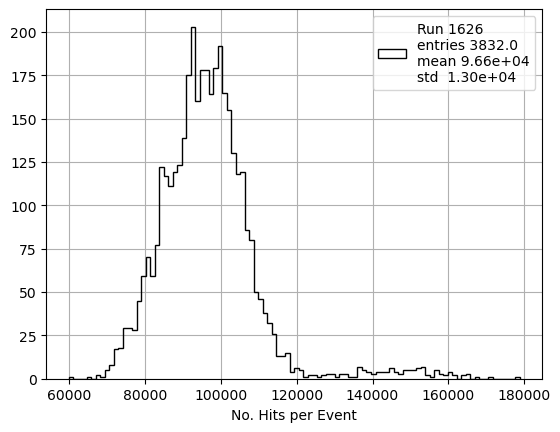

In [14]:
pltext.hist(nhits, 100, ylog=False, xylabels="No. Hits per Event", formate=".2e", label=f"Run {run}");